In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# 1. 데이터 로드
file_path = "/content/drive/MyDrive/Colab Notebooks/combined_dataset.xlsx"
df = pd.read_excel(file_path)

# 2. 입력 및 타겟 분리
X_raw = df[[str(i) for i in range(1, 2101)]].dropna()
y_sbp = df.loc[X_raw.index, 'Systolic Blood Pressure(mmHg)']
y_dbp = df.loc[X_raw.index, 'Diastolic Blood Pressure(mmHg)']

y = np.stack([y_sbp.values, y_dbp.values], axis=1)  # (N, 2)

# 3. 표준화 및 텐서 변환
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw.values)  # (N, 2100)

X_tensor = torch.tensor(X_scaled, dtype=torch.float32).unsqueeze(1)  # [N, 1, 2100]
y_tensor = torch.tensor(y, dtype=torch.float32)  # [N, 2]

# 4. Data Splitting
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25*0.8 = 0.2

# 5. DataLoader
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32, shuffle=False)

print("Shapes:")
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Val: {X_val.shape}, {y_val.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")

Shapes:
Train: torch.Size([393, 1, 2100]), torch.Size([393, 2])
Val: torch.Size([132, 1, 2100]), torch.Size([132, 2])
Test: torch.Size([132, 1, 2100]), torch.Size([132, 2])


In [174]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# RevIN: Reversible Instance Normalization
class RevIN(nn.Module):
    def __init__(self, num_features, eps=1e-5, affine=True, subtract_last=True):
        super().__init__()
        self.num_features = num_features
        self.eps = eps
        self.affine = affine
        self.subtract_last = subtract_last
        if self.affine:
            self.affine_weight = nn.Parameter(torch.ones(1, num_features, 1))
            self.affine_bias = nn.Parameter(torch.zeros(1, num_features, 1))

    def forward(self, x, mode):
        if mode == 'norm':
            self._get_statistics(x)
            x = self._normalize(x)
        elif mode == 'denorm':
            x = self._denormalize(x)
        else:
            raise NotImplementedError
        return x

    def _get_statistics(self, x):
        dim = tuple(range(1, x.ndim - 1))
        if self.subtract_last:
            self.last = x[:, -1, :].unsqueeze(1)
        else:
            self.mean = x.mean(dim=dim, keepdim=True).detach()
        self.stdev = (x.var(dim=dim, keepdim=True, unbiased=False) + self.eps).sqrt().detach()

    def _normalize(self, x):
        x = (x - (self.last if self.subtract_last else self.mean)) / self.stdev
        if self.affine:
            x = x * self.affine_weight + self.affine_bias
        return x

    def _denormalize(self, x):
        if self.affine:
            x = (x - self.affine_bias) / (self.affine_weight + self.eps * self.eps)
        x = x * self.stdev + (self.last if self.subtract_last else self.mean)
        return x

# LayerNorm (채널 기준 LayerNorm)
class LayerNorm(nn.Module):
    def __init__(self, num_features, eps=1e-6):
        super().__init__()
        self.norm = nn.LayerNorm(num_features, eps=eps)

    def forward(self, x):
        # x: [B, C, L] → transpose → apply norm → transpose back
        return self.norm(x.transpose(-1, -2)).transpose(-1, -2)

# conv_bn: Conv1d + BatchNorm1d
def conv_bn(in_channels, out_channels, kernel_size, stride, padding, groups, dilation=1, bias=False):
    if padding is None:
        padding = kernel_size // 2
    return nn.Sequential(
        nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias),
        nn.BatchNorm1d(out_channels)
    )

# Reparameterized Large Kernel Convolution
class ReparamLargeKernelConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, groups=1, small_kernel=None, small_kernel_merged=False):
        super().__init__()
        padding = kernel_size // 2
        if small_kernel_merged:
            self.lkb_reparam = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, groups=groups, bias=True)
        else:
            self.lkb_origin = conv_bn(in_channels, out_channels, kernel_size, stride, padding, groups)
            if small_kernel:
                self.small_conv = conv_bn(in_channels, out_channels, small_kernel, stride, small_kernel // 2, groups)

    def forward(self, x):
        if hasattr(self, 'lkb_reparam'):
            return self.lkb_reparam(x)
        out = self.lkb_origin(x)
        if hasattr(self, 'small_conv'):
            out += self.small_conv(x)
        return out

# Block: Large kernel conv + FFN with residual connection
class Block(nn.Module):
    def __init__(self, dmodel, dff, nvars, large_size, small_size, small_kernel_merged=False, drop=0.1):
        super().__init__()
        self.conv = ReparamLargeKernelConv(dmodel, dmodel, large_size, groups=dmodel, small_kernel=small_size)
        self.norm = LayerNorm(dmodel)
        self.ffn = nn.Sequential(
            nn.Conv1d(dmodel, dff, kernel_size=1, groups=dmodel),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Conv1d(dff, dmodel, kernel_size=1, groups=dmodel),
            nn.Dropout(drop)
        )

    def forward(self, x):
        res = x
        x = self.norm(self.conv(x))
        x = self.ffn(x)
        return res + x

# Stage: 여러 Block을 쌓음
class Stage(nn.Module):
    def __init__(self, ffn_ratio, num_blocks, large_size, small_size, dmodel, dw_model, nvars,
                 small_kernel_merged=False, drop=0.1):
        super().__init__()
        d_ffn = dmodel * ffn_ratio
        self.blocks = nn.ModuleList([
            Block(dmodel, d_ffn, nvars, large_size, small_size, small_kernel_merged, drop)
            for _ in range(num_blocks)
        ])

    def forward(self, x):
        for blk in self.blocks:
            x = blk(x)
        return x

# ModernTCN: 시계열 데이터를 다루는 컨볼루션 기반 백본
class ModernTCN(nn.Module):
    def __init__(self, task_name, patch_size, patch_stride, stem_ratio, downsample_ratio, ffn_ratio, num_blocks,
                 large_size, small_size, dims, dw_dims, nvars, small_kernel_merged=False, backbone_dropout=0.1,
                 head_dropout=0.1, use_multi_scale=True, revin=True, affine=True, subtract_last=False,
                 freq=None, seq_len=512, c_in=7, individual=False, target_window=96, class_drop=0., class_num=3):
        super().__init__()
        self.patch_size = patch_size
        self.patch_stride = patch_stride
        self.task_name = task_name
        self.downsample_ratio = downsample_ratio
        self.num_stage = len(num_blocks)
        self.revin = revin
        if self.revin:
            self.revin_layer = RevIN(c_in, affine=affine, subtract_last=subtract_last)
        # stem: 첫번째 conv 계층 (padding은 kernel_size//2로 자동 적용)
        self.stem = nn.Sequential(
            nn.Conv1d(in_channels=nvars, out_channels=dims[0],
                      kernel_size=patch_size, stride=patch_stride, padding=patch_size//2),
            nn.BatchNorm1d(dims[0])
        )
        self.downsample_layers = nn.ModuleList([self.stem])
        for i in range(self.num_stage - 1):
            self.downsample_layers.append(nn.Sequential(
                nn.BatchNorm1d(dims[i]),
                nn.Conv1d(dims[i], dims[i + 1], kernel_size=downsample_ratio, stride=downsample_ratio, padding=downsample_ratio//2)
            ))
        self.stages = nn.ModuleList()
        for i in range(self.num_stage):
            self.stages.append(Stage(
                ffn_ratio, num_blocks[i], large_size[i], small_size[i],
                dmodel=dims[i], dw_model=dw_dims[i], nvars=nvars,
                small_kernel_merged=small_kernel_merged, drop=backbone_dropout
            ))

    def forward_feature(self, x):
        for i in range(self.num_stage):
            B, C, N = x.shape
            if i == 0 and self.patch_size != self.patch_stride:
                pad_len = self.patch_size - self.patch_stride
                x = torch.cat([x, x[:, :, -1:].repeat(1, 1, pad_len)], dim=-1)
            if N % self.downsample_ratio != 0:
                pad_len = self.downsample_ratio - (N % self.downsample_ratio)
                x = torch.cat([x, x[:, :, -pad_len:]], dim=-1)
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)
        return x

    def forward(self, x):
        return self.forward_feature(x)

# ResidualBlock: 두 개의 conv 계층과 ELU 활성화 (padding은 kernel_size//2 적용)
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(channels),
            nn.ELU(),
            nn.Conv1d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(channels)
        )
        self.elu = nn.ELU()

    def forward(self, x):
        return self.elu(x + self.conv(x))

# ShallowEncoder: MaxPool1d 제거, padding 적용
class ShallowEncoder(nn.Module):
    def __init__(self, in_channels, cnn_channels, kernel_size=15):
        super().__init__()
        self.initial_conv = nn.Conv1d(in_channels, cnn_channels, kernel_size=1)
        self.temporal_conv = nn.Sequential(
            nn.Conv1d(cnn_channels, cnn_channels, kernel_size, padding=kernel_size//2),
            nn.BatchNorm1d(cnn_channels),
            nn.ELU(),
            # MaxPool1d 제거
            ResidualBlock(cnn_channels)
        )

    def forward(self, x):
        x = self.initial_conv(x)
        return self.temporal_conv(x)

# FineTemporalBranch: MaxPool1d 제거, padding 적용
class FineTemporalBranch(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(d_model, d_model, kernel_size=5, padding=5//2),
            nn.BatchNorm1d(d_model),
            nn.ELU(),
            # MaxPool1d 제거
            ResidualBlock(d_model)
        )

    def forward(self, x):
        return self.conv(x)

# CoarseTransformerBranch: Transformer Encoder 기반
class CoarseTransformerBranch(nn.Module):
    def __init__(self, d_model, nhead):
        super().__init__()
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=0.1, batch_first=True),
            num_layers=3
        )

    def forward(self, x):
        return self.encoder(x)

class ProjectionHead(nn.Module):
    def __init__(self, d_model, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_model)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(d_model, output_dim)

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

# Model: 반복 블록 내에 ModernTCN, ShallowEncoder, FineTemporalBranch, CoarseTransformerBranch, channel_adjust 적용
class Model(nn.Module):
    def __init__(self, configs):
        super(Model, self).__init__()
        self.revin = configs.get('revin', False)
        self.input_dim = configs['input_dim']      # 예: 원본 채널 수 (예를 들어 1)
        self.output_dim = configs['output_dim']
        self.num_repeat_blocks = configs.get('num_repeat_blocks', 8)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        if self.revin:
            self.revin_layer = RevIN(self.input_dim, affine=configs.get('affine', True),
                                      subtract_last=configs.get('subtract_last', False))

        self.d_model = configs['dims'][-1]  # 예: 256

        # 반복 블록 구성: 첫 블록은 입력 채널 = input_dim, 이후는 d_model
        self.repeated_blocks = nn.ModuleList()
        for i in range(self.num_repeat_blocks):
            in_ch = self.input_dim if i == 0 else self.d_model
            block = nn.ModuleDict({
                'tcn': ModernTCN(
                    task_name='regression',
                    nvars=in_ch,
                    class_num=self.output_dim,
                    patch_size=configs['kernel_size'],
                    small_size=configs['small_size'],
                    target_window=configs['target_window'],
                    num_blocks=configs['num_blocks'],
                    dims=configs['dims'],
                    dw_dims=configs['dw_dims'],
                    backbone_dropout=configs['dropout'],
                    patch_stride=configs['patch_stride'],
                    stem_ratio=configs['stem_ratio'],
                    downsample_ratio=configs['downsample_ratio'],
                    ffn_ratio=configs['ffn_ratio'],
                    large_size=configs['large_size']
                ),
                'project': ShallowEncoder(in_channels=self.d_model, cnn_channels=self.d_model, kernel_size=15),
                'fine': FineTemporalBranch(self.d_model),
                'coarse': CoarseTransformerBranch(d_model=self.d_model, nhead=configs['num_heads']),
                'channel_adjust': nn.Conv1d(2 * self.d_model, self.d_model, kernel_size=1)
            })
            self.repeated_blocks.append(block)

        self.projection = ProjectionHead(self.d_model, self.output_dim)

    def forward(self, x):
        # x: [B, C, L]
        if self.revin:
            x = x.permute(0, 2, 1)  # [B, L, C]
            x = self.revin_layer(x, mode='norm')
            x = x.permute(0, 2, 1)  # [B, C, L]
        for block in self.repeated_blocks:
            x = block['tcn'](x)               # [B, d_model, L']
            x = block['project'](x)           # [B, d_model, L']
            x_fine = block['fine'](x)         # [B, d_model, L']
            x_trans = x_fine.permute(0, 2, 1)   # [B, L', d_model]
            x_coarse = block['coarse'](x_trans).permute(0, 2, 1)  # [B, d_model, L']
            x = torch.cat([x_fine, x_coarse], dim=1)  # [B, 2*d_model, L']
            x = block['channel_adjust'](x)            # [B, d_model, L']
        x = self.global_pool(x).squeeze(-1)
        out = self.projection(x)  # [B, output_dim]
        return out


In [175]:
configs = {
    'input_dim': 1,           # 1채널 (e.g., RED or IR or dPPG)
    'output_dim': 2,          # SBP, DBP

    # patch 설정: Conv1d 첫 입력용
    'kernel_size': 21,        # patch_size → 입력길이 2100에 비해 적당한 시작 커널
    'patch_stride': 10,       # patch_stride → 충분한 시계열 커버 가능

    'small_size': [3, 3, 3],  # depth-wise 작은 커널
    'target_window': 1,       # 회귀 문제이므로 1

    # TCN 블록 수
    'num_blocks': [2, 2, 2],
    'dims': [64, 128, 256],
    'dw_dims': [64, 128, 256],

    'dropout': 0.1,
    'stem_ratio': 1,
    'downsample_ratio': 2,    # 2100 → 약 262 → 약 65 → 약 32 까지 감소

    'ffn_ratio': 4,
    'large_size': [21, 11, 5], # depth-wise 큰 커널

    'num_heads': 8,
    'revin': True
}


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Model(configs).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

criterion = nn.HuberLoss(delta=1.0, reduction='mean')  # delta: 임계값




In [176]:
num_epochs = 30

In [177]:
from tqdm import tqdm
import numpy as np
import torch

best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    total_train = 0

    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x.size(0)
        total_train += x.size(0)

    model.eval()
    val_loss = 0
    total_val = 0
    preds, targets = [], []

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)

            val_loss += loss.item() * x.size(0)
            total_val += x.size(0)

            preds.append(outputs.cpu())
            targets.append(y.cpu())

    # 평균 loss 계산
    train_loss /= total_train
    val_loss /= total_val

    # MAE 계산
    preds = torch.cat(preds).numpy()
    targets = torch.cat(targets).numpy()
    mae = np.mean(np.abs(preds - targets))

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, MAE: {mae:.2f}")

    # Best model 저장
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print("✅ Best model updated and saved.")


Epoch 1 [Train]: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


Epoch 1: Train Loss: 83.8994, Val Loss: 35.6275, MAE: 36.13
✅ Best model updated and saved.


Epoch 2 [Train]: 100%|██████████| 13/13 [00:05<00:00,  2.53it/s]


Epoch 2: Train Loss: 22.6860, Val Loss: 24.1915, MAE: 24.69
✅ Best model updated and saved.


Epoch 3 [Train]: 100%|██████████| 13/13 [00:04<00:00,  2.66it/s]


Epoch 3: Train Loss: 14.2828, Val Loss: 13.0651, MAE: 13.56
✅ Best model updated and saved.


Epoch 4 [Train]: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


Epoch 4: Train Loss: 13.1688, Val Loss: 18.7549, MAE: 19.25


Epoch 5 [Train]: 100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


Epoch 5: Train Loss: 13.5754, Val Loss: 13.4225, MAE: 13.92


Epoch 6 [Train]: 100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


Epoch 6: Train Loss: 14.0357, Val Loss: 14.5548, MAE: 15.05


Epoch 7 [Train]: 100%|██████████| 13/13 [00:04<00:00,  2.76it/s]


Epoch 7: Train Loss: 12.6623, Val Loss: 12.9167, MAE: 13.41
✅ Best model updated and saved.


Epoch 8 [Train]: 100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


Epoch 8: Train Loss: 12.7477, Val Loss: 11.7124, MAE: 12.20
✅ Best model updated and saved.


Epoch 9 [Train]: 100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


Epoch 9: Train Loss: 12.6295, Val Loss: 12.4351, MAE: 12.92


Epoch 10 [Train]: 100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


Epoch 10: Train Loss: 12.9111, Val Loss: 12.0464, MAE: 12.54


Epoch 11 [Train]: 100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


Epoch 11: Train Loss: 12.9866, Val Loss: 12.6644, MAE: 13.16


Epoch 12 [Train]: 100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


Epoch 12: Train Loss: 12.2384, Val Loss: 12.4570, MAE: 12.95


Epoch 13 [Train]: 100%|██████████| 13/13 [00:05<00:00,  2.50it/s]


Epoch 13: Train Loss: 12.1313, Val Loss: 11.6499, MAE: 12.14
✅ Best model updated and saved.


Epoch 14 [Train]: 100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


Epoch 14: Train Loss: 12.0120, Val Loss: 13.0572, MAE: 13.55


Epoch 15 [Train]: 100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


Epoch 15: Train Loss: 13.2406, Val Loss: 12.1479, MAE: 12.64


Epoch 16 [Train]: 100%|██████████| 13/13 [00:04<00:00,  2.76it/s]


Epoch 16: Train Loss: 12.7853, Val Loss: 11.6516, MAE: 12.14


Epoch 17 [Train]: 100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


Epoch 17: Train Loss: 12.2244, Val Loss: 11.8264, MAE: 12.32


Epoch 18 [Train]: 100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


Epoch 18: Train Loss: 12.3030, Val Loss: 11.6541, MAE: 12.14


Epoch 19 [Train]: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


Epoch 19: Train Loss: 12.0874, Val Loss: 12.0214, MAE: 12.51


Epoch 20 [Train]: 100%|██████████| 13/13 [00:04<00:00,  2.70it/s]


Epoch 20: Train Loss: 12.0341, Val Loss: 11.7402, MAE: 12.23


Epoch 21 [Train]: 100%|██████████| 13/13 [00:04<00:00,  2.73it/s]


Epoch 21: Train Loss: 12.2188, Val Loss: 11.7793, MAE: 12.27


Epoch 22 [Train]: 100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


Epoch 22: Train Loss: 12.6600, Val Loss: 11.6188, MAE: 12.11
✅ Best model updated and saved.


Epoch 23 [Train]: 100%|██████████| 13/13 [00:04<00:00,  2.66it/s]


Epoch 23: Train Loss: 12.1882, Val Loss: 11.8056, MAE: 12.30


Epoch 24 [Train]: 100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


Epoch 24: Train Loss: 12.0189, Val Loss: 11.8119, MAE: 12.30


Epoch 25 [Train]: 100%|██████████| 13/13 [00:04<00:00,  2.68it/s]


Epoch 25: Train Loss: 11.9792, Val Loss: 13.4001, MAE: 13.89


Epoch 26 [Train]: 100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


Epoch 26: Train Loss: 12.2811, Val Loss: 12.3574, MAE: 12.85


Epoch 27 [Train]: 100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


Epoch 27: Train Loss: 12.0865, Val Loss: 12.6138, MAE: 13.10


Epoch 28 [Train]: 100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


Epoch 28: Train Loss: 12.6848, Val Loss: 12.2660, MAE: 12.76


Epoch 29 [Train]: 100%|██████████| 13/13 [00:04<00:00,  2.70it/s]


Epoch 29: Train Loss: 12.0455, Val Loss: 11.8058, MAE: 12.30


Epoch 30 [Train]: 100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


Epoch 30: Train Loss: 12.3238, Val Loss: 14.9768, MAE: 15.47


✅ SBP  | RMSE: 20.99 | MAE: 16.80 | R²: -0.012
✅ DBP  | RMSE: 11.98 | MAE: 9.61 | R²: -0.019

📌 SBP 예측 vs 실제 (상위 10개)
Sample 1: True = 102.0, Pred = 126.8
Sample 2: True = 123.0, Pred = 126.9
Sample 3: True = 128.0, Pred = 128.6
Sample 4: True = 115.0, Pred = 128.6
Sample 5: True = 125.0, Pred = 126.8
Sample 6: True = 139.0, Pred = 126.8
Sample 7: True = 111.0, Pred = 128.6
Sample 8: True = 117.0, Pred = 128.6
Sample 9: True = 182.0, Pred = 126.8
Sample 10: True = 116.0, Pred = 126.8

📌 DBP 예측 vs 실제 (상위 10개)
Sample 1: True = 66.0, Pred = 73.1
Sample 2: True = 68.0, Pred = 73.1
Sample 3: True = 64.0, Pred = 73.6
Sample 4: True = 64.0, Pred = 73.6
Sample 5: True = 62.0, Pred = 73.1
Sample 6: True = 85.0, Pred = 73.1
Sample 7: True = 70.0, Pred = 73.6
Sample 8: True = 68.0, Pred = 73.6
Sample 9: True = 102.0, Pred = 73.1
Sample 10: True = 66.0, Pred = 73.1


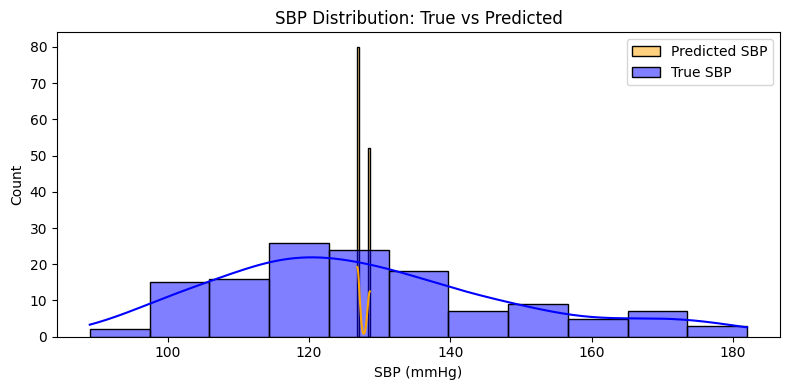

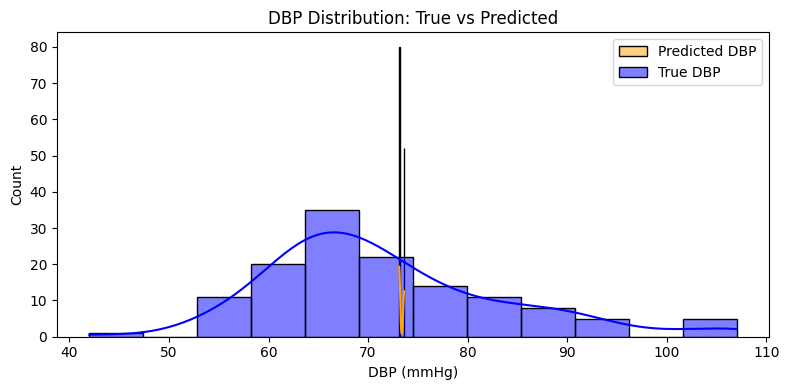

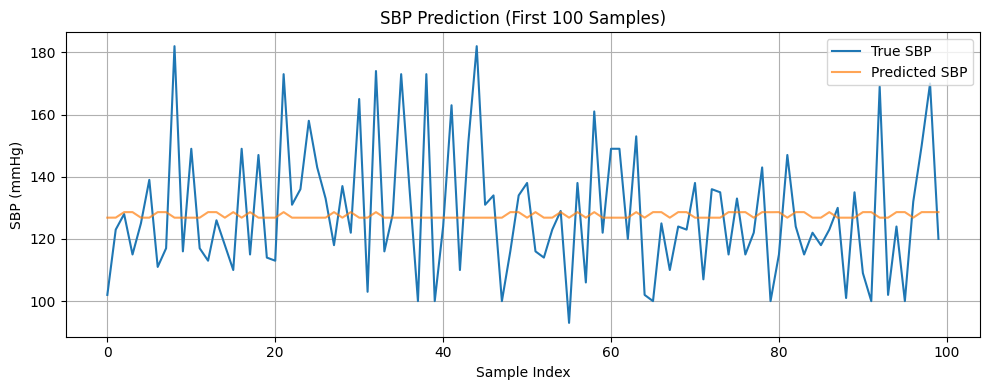

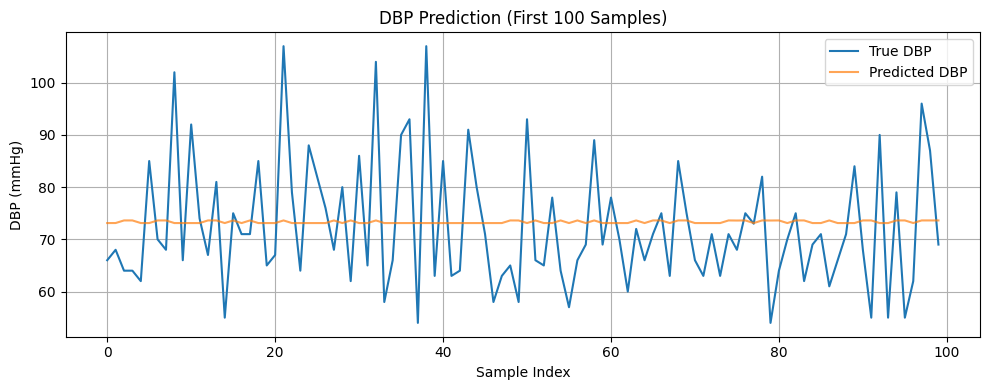

In [173]:
def evaluate_model(model, test_loader, device, plot_range=100):
    model.eval()
    model.to(device)

    preds_list = []
    labels_list = []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            preds_list.append(preds.cpu().numpy())
            labels_list.append(yb.cpu().numpy())

    all_preds = np.vstack(preds_list)
    all_labels = np.vstack(labels_list)

    # 분리
    sbp_true, dbp_true = all_labels[:, 0], all_labels[:, 1]
    sbp_pred, dbp_pred = all_preds[:, 0], all_preds[:, 1]

    # 평가 지표 계산
    sbp_rmse = np.sqrt(mean_squared_error(sbp_true, sbp_pred))
    sbp_mae = mean_absolute_error(sbp_true, sbp_pred)
    sbp_r2 = r2_score(sbp_true, sbp_pred)

    dbp_rmse = np.sqrt(mean_squared_error(dbp_true, dbp_pred))
    dbp_mae = mean_absolute_error(dbp_true, dbp_pred)
    dbp_r2 = r2_score(dbp_true, dbp_pred)

    print(f"✅ SBP  | RMSE: {sbp_rmse:.2f} | MAE: {sbp_mae:.2f} | R²: {sbp_r2:.3f}")
    print(f"✅ DBP  | RMSE: {dbp_rmse:.2f} | MAE: {dbp_mae:.2f} | R²: {dbp_r2:.3f}")

    # 예측값 샘플 출력
    print("\n📌 SBP 예측 vs 실제 (상위 10개)")
    for i in range(10):
        print(f"Sample {i+1}: True = {sbp_true[i]:.1f}, Pred = {sbp_pred[i]:.1f}")

    print("\n📌 DBP 예측 vs 실제 (상위 10개)")
    for i in range(10):
        print(f"Sample {i+1}: True = {dbp_true[i]:.1f}, Pred = {dbp_pred[i]:.1f}")

    # SBP 분포 시각화
    import seaborn as sns
    plt.figure(figsize=(8, 4))
    sns.histplot(sbp_pred, label='Predicted SBP', color='orange', kde=True)
    sns.histplot(sbp_true, label='True SBP', color='blue', kde=True, alpha=0.5)
    plt.title("SBP Distribution: True vs Predicted")
    plt.xlabel("SBP (mmHg)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # DBP 분포 시각화
    plt.figure(figsize=(8, 4))
    sns.histplot(dbp_pred, label='Predicted DBP', color='orange', kde=True)
    sns.histplot(dbp_true, label='True DBP', color='blue', kde=True, alpha=0.5)
    plt.title("DBP Distribution: True vs Predicted")
    plt.xlabel("DBP (mmHg)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 기존 시각화
    plt.figure(figsize=(10, 4))
    plt.plot(sbp_true[:plot_range], label='True SBP')
    plt.plot(sbp_pred[:plot_range], label='Predicted SBP', alpha=0.7)
    plt.title(f"SBP Prediction (First {plot_range} Samples)")
    plt.xlabel("Sample Index")
    plt.ylabel("SBP (mmHg)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(dbp_true[:plot_range], label='True DBP')
    plt.plot(dbp_pred[:plot_range], label='Predicted DBP', alpha=0.7)
    plt.title(f"DBP Prediction (First {plot_range} Samples)")
    plt.xlabel("Sample Index")
    plt.ylabel("DBP (mmHg)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return (sbp_true, sbp_pred), (dbp_true, dbp_pred)

model.load_state_dict(torch.load('best_model.pth'))

# 평가 및 시각화 실행
labels, preds = evaluate_model(model, test_loader, device, plot_range=100)